In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')
import matplotlib.pyplot as plt

old_stdout = sys.__stdout__

In [2]:
# dataset
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]
        image = image.reshape(784)
        return image, label

def get_dataloader(x, y, batch_size, num_worker, shuffle):
    '''Use PyTorch Dataset to enable multiprocessing to prepare data.
    '''
    dataset = Data(x, y)
    
    init_fun = np.random.seed()
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_worker,
        worker_init_fn=init_fun
    )
    return dataloader

Variational Auto-encoder ELBO:

\begin{align}
& E_{q(z|x)} [\log p(x,z) - \log q(z|x)] \\
= & E_{q(z|x)} [\log p(x|z)] - KL[q(z|x)||p(z)] \\
\propto & - \sum_{i=1}^N (\hat x_i - x_i)^2 - \sum_{i=1}^K KL(q_{z_i|x}||p(z_i))
\end{align}
where $N$ and $K$ is the dimension of the input and latent variable, respectively.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions

from datetime import datetime
def print_log(*args):
    print("[{}]".format(datetime.now()), *args)
    sys.stdout.flush()
    
def _log_xexp_ratio(x):
  """Compute log(x * (exp(x) + 1) / (exp(x) - 1)) in a numerically stable way.
  
  Get this from https://github.com/tensorflow/probability/blob/4683836be3701e75f459494bd3de12edb7560a2d/tensorflow_probability/python/distributions/continuous_bernoulli.py#L37
  """
  with tf.name_scope('log_xexp_ratio'):
    x = tf.convert_to_tensor(x)
    dtype = tf.dtypes.as_dtype(x.dtype)
    eps = np.finfo(dtype.as_numpy_dtype).eps

    # This function is even, hence we use abs(x) everywhere.
    x = tf.math.abs(x)

    # For x near zero, we have the Taylor series:
    # log(2) + x**2 / 12 - 7 x**4 / 1440 + 31 x**6 / 90720 + O(x**8)
    # whose coefficients decrease in magnitude monotonically

    # For x large in magnitude, the ratio (exp(x) + 1) / (exp(x) - 1)) tends to
    # sign(x), so thus this function should tend to log(abs(x))

    # Finally for x medium in magnitude, we can use the naive expression. Thus,
    # we generate 2 cutofs.

    # Use the first 3 non-zero terms of the Taylor series when
    # |x| < small_cutoff.
    small_cutoff = np.power(eps * 90720. / 31, 1 / 6.)

    # Use log(abs(x)) when |x| > large_cutoff
    large_cutoff = -np.log(eps)

    x_squared = tf.math.square(x)

    result = (tf.cast(np.log(2.), dtype) + x_squared / 112. -
              7 * tf.math.square(x_squared) / 1440.)
    middle_region = (x > small_cutoff) & (x < large_cutoff)
    safe_x_medium = tf.where(middle_region, x, tf.ones_like(x, dtype=dtype))
    result = tf.where(
        middle_region,
        (tf.math.log(safe_x_medium) + tf.math.softplus(safe_x_medium) -
         tf.math.log(tf.math.expm1(safe_x_medium))),
        result)

    # We can do this by choosing a cutoff when x > log(1 / machine eps)
    safe_x_large = tf.where(x >= large_cutoff, x, tf.ones_like(x, dtype=dtype))
    result = tf.where(x >= large_cutoff, tf.math.log(safe_x_large), result)
    return result

def _mean(logits):
    # The mean is probs / (2 * probs - 1) + 1 / (2 * arctanh(1 - 2 * probs))
    # with the removable singularity at 0.5 removed.
    # We write this in logits space.
    # The first term becomes
    # 1 / (1 + exp(-logits)) / (2 / (1 + exp(-logits)) - 1) =
    # 1 / (2 - 1 - exp(-logits)) =
    # 1 / (1 - exp(-logits))
    # The second term becomes 1 / logits.
    # Thus we have mean = 1 / (1 - exp(-logits)) - 1 / logits.

    # When logits is close to zero, we can compute the Laurent series for the
    # first term as:
    # 1 / x + 1 / 2 + x / 12 - x**3 / 720 + x**5 / 30240 + O(x**7).
    # Thus we get the pole at zero canceling out with the second term.

    dtype = tf.dtypes.as_dtype(logits.dtype)
    eps = np.finfo(dtype.as_numpy_dtype).eps

    small_cutoff = np.power(eps * 30240, 1 / 5.)
    result = tf.constant(0.5, dtype=dtype) + logits / 12. - logits * tf.math.square(logits) / 720

    safe_logits_large = tf.where(
        tf.math.abs(logits) > small_cutoff, logits, tf.ones_like(logits, dtype=dtype))
    return tf.where(
        tf.math.abs(logits) > small_cutoff,
        -(tf.math.reciprocal(
            tf.math.expm1(-safe_logits_large)) +
          tf.math.reciprocal(safe_logits_large)),
        result)


class VariationalAutoEncoder:
    def __init__(self, x_dim, z_dim, net_size, lr=0.001, kl_weight=1.0):
        
        # 'z_dim, activation, loss' can be tuned
        
        # reset the default graph otherwise the variable initialization will get
        # slower because all models create the variables and operations in the
        # same graph
        tf.reset_default_graph()
        
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.lr = lr
        self.kl_weight = kl_weight
        
        with tf.compat.v1.variable_scope('placeholder'):
            x_shape = [None] + [self.x_dim]
            self.x = tf.placeholder(
                tf.float32, 
                shape=x_shape)
        
        with tf.compat.v1.variable_scope('networks'):
            self.recog = keras.Sequential(
                [
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(self.z_dim*2, activation=None),
                ]
            )
            self.gen = keras.Sequential(
                [
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(self.x_dim, activation=None),
                ]
            )
        
        with tf.compat.v1.variable_scope('z'):
            self.p_z = tfd.Normal(
                loc=[0.] * self.z_dim,
                scale=[1.] * self.z_dim,
                name='p_z_dist')
            
            self.z_param = self.recog(self.x)
            self.z_mean = self.z_param[:, :self.z_dim]
            self.z_std = tf.math.softplus(self.z_param[:, self.z_dim:])

            self.q_z = tfd.Normal(
                loc=self.z_mean,
                scale=self.z_std,
                name='q_z_dist')
            
            self.z = self.q_z.sample()
            
        with tf.compat.v1.variable_scope('x'):
            self.re_x_logit = self.gen(self.z)
            self.p_re_x = tfd.Bernoulli(logits=self.re_x_logit, name='p_x_z_dist')
            self.re_x = _mean(self.re_x_logit)
        
        with tf.compat.v1.variable_scope('training_loss'):
            self.rec_error = -tf.reduce_sum(
                self.p_re_x.log_prob(self.x) + _log_xexp_ratio(self.re_x_logit), axis=-1)
            self.kl_loss = tf.reduce_sum(tfd.kl_divergence(self.q_z, self.p_z, name='KL'), axis=-1)
            self.nelbo = self.rec_error + self.kl_weight * self.kl_loss
            self.ave_nelbo = tf.reduce_mean(self.nelbo)
        
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.lr)
        self.train_step = self.optimizer.minimize(self.ave_nelbo)
        
        # sample from prior
        self.z_from_prior = self.p_z.sample()
        self.x_sample_logit = self.gen(tf.expand_dims(self.z_from_prior, axis=0))
#         self.p_x_sample = tfd.Bernoulli(logits=self.x_sample_logit)
        self.x_sample = _mean(self.x_sample_logit)
        
    # initialization
    def init_session(self):
        # Initializing the variables
        init = tf.global_variables_initializer()

        # launch a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = False #True
        self.sess = tf.Session(config=config)

        self.sess.run(init)
        
    def train(self, tr_loader, no_epochs=500, te_loader=None):
        costs = []
        rec_error = []
        kl_loss = []
        
        for epoch_idx in range(no_epochs):
            epoch_cost = 0.
            epoch_lik_cost = 0.
            epoch_kl_cost = 0.
            for batch_idx, tr_batch in enumerate(tr_loader):
                tr_x, _, = tr_batch
                _, cost, kl, rec = self.sess.run(
                    [
                        self.train_step,
                        self.ave_nelbo,
                        self.kl_loss,
                        self.rec_error
                    ],
                    feed_dict={
                        self.x: tr_x
                    }
                )
                
                epoch_cost += cost
                epoch_lik_cost += np.mean(rec)
                epoch_kl_cost += np.mean(kl)
                
                costs.append(cost)
                rec_error.append(np.mean(rec))
                kl_loss.append(np.mean(kl))
                
            batch_idx += 1
            epoch_cost /= batch_idx
            epoch_lik_cost /= batch_idx
            epoch_kl_cost /= batch_idx
            
            print_log("Epoch:", '%04d' % (epoch_idx+1), 
                "total cost=", 
                "{:.9f}".format(epoch_cost), 
                "log-likelihood term=", 
                "{:.9f}".format(epoch_lik_cost), 
                "kl/regluarization term=", 
                "{:.9f}".format(epoch_cost - epoch_lik_cost))
            
        return costs, rec_error, kl_loss

In [4]:
mini_batchsize = 64
no_epochs = 50
lr = 0.001
z_dim = 100
net_size = 200

# data
(x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = np.squeeze(y_train)
x_test = x_test.astype('float32')
y_test = np.squeeze(y_test)
x_train /= 255
x_test /= 255

mnist_tr_loader = get_dataloader(x_train, y_train, mini_batchsize, 4, True)

# model
vae = VariationalAutoEncoder(x_dim=784, z_dim=z_dim, net_size=net_size, lr=lr)
vae.init_session()

# train
costs, rec_error, kl_loss = vae.train(mnist_tr_loader, no_epochs=no_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[2021-06-07 10:16:00.382121] Epoch: 0001 total cost= -2987.252833179 log-likelihood term= -3028.224892944 kl/regluarization term= 40.972059765
[2021-06-07 10:16:05.672139] Epoch: 0002 total cost= -3802.855471873 log-likelihood term= -3865.105173595 kl/regluarization term= 62.249701722
[2021-06-07 10:16:10.949859] Epoch: 0003 total cost= -4096.618165884 log-likelihood term= -4164.779433521 kl/regluarization term= 68.161267636
[2021-06-07 10:16:16.160451] Epoch: 0004 total cost= -4302.275869276 log-likelihood term= -4373.104072620 kl/regluarization term= 70.828203344
[2021-06-07 10:16:21.196858] Epoch: 0005 total cost= -4458.620894637 log-likelihood term= -4531.636338744 kl/regluarization term= 73.015444107
[2021-06-07 10:16:26.333074] Epoch: 0006 total cost= -4591.828123178 log-likelihood term= -4667.114217730 kl/r

/home/aodongl1/.conda/envs/py3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: tight_layout : falling back to Agg renderer


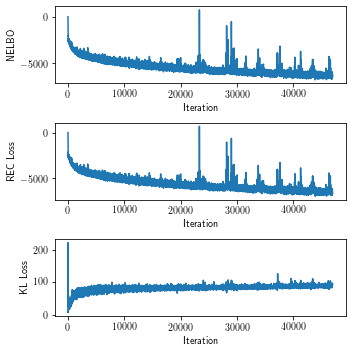

In [5]:
fig = plt.Figure(figsize=[5,5])
axes = fig.subplots(3,1)

ax = axes[0]
ax.plot(costs)
ax.set_xlabel('Iteration')
ax.set_ylabel('NELBO')

ax = axes[1]
ax.plot(rec_error)
ax.set_xlabel('Iteration')
ax.set_ylabel('REC Loss')

ax = axes[2]
ax.plot(kl_loss)
ax.set_xlabel('Iteration')
ax.set_ylabel('KL Loss')

fig.tight_layout()
fig

**Note that the following samples are not exactly from Continuous Bernoulli distribution! They are from the Bernoulli parameterized by the CB's parameter.**

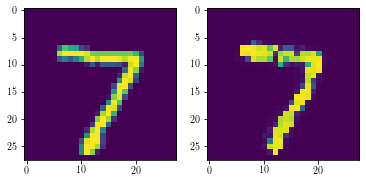

In [6]:
# reconstruct a test image
x_te = x_test[0]
x_te = x_te.reshape(784)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

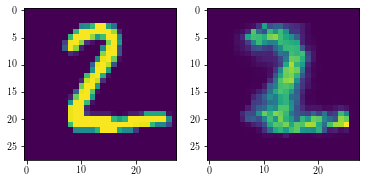

In [7]:
# reconstruct a test image
x_te = x_test[1]
x_te = x_te.reshape(784)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

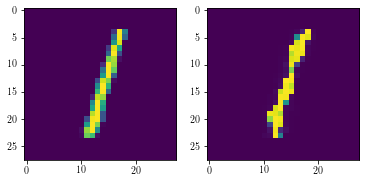

In [8]:
# reconstruct a test image
x_te = x_test[2]
x_te = x_te.reshape(784)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

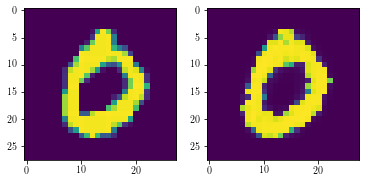

In [9]:
# reconstruct a test image
x_te = x_test[3]
x_te = x_te.reshape(784)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

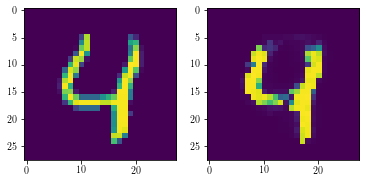

In [10]:
# reconstruct a test image
x_te = x_test[4]
x_te = x_te.reshape(784)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

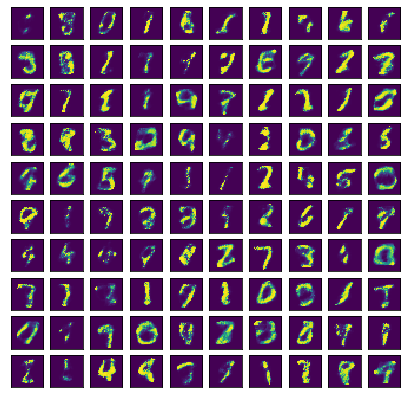

In [11]:
# samples
fig = plt.Figure(figsize=(7,7))
axes = fig.subplots(10,10)

for i in range(10):
    for j in range(10):
        ax = axes[i,j]
        
        re_x = vae.sess.run([vae.x_sample])[0]
        
        ax.imshow(re_x.reshape(28,28))
        ax.set_xticks([])
        ax.set_xticks([], minor=True)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)

fig